In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys

sys.path.append('./helpers_models/')
sys.path.append('./data_visualization_and_augmentations/')
sys.path.append('../torch_videovision/')
sys.path.append('./important_csvs/')

from helpers_resnet import *

resnet = torchvision.models.resnet50(pretrained=True)
adaptive_pooling = AdaptiveConcatPool2d()
head = Head()
resnet.avgpool = adaptive_pooling
resnet.fc = head

os.environ['CUDA_VISIBLE_DEVICES']='0' #,1,2

resnet = resnet.cuda()

for param in resnet.parameters():
    param.requires_grad = False
    
for param in resnet.avgpool.parameters():
    param.requires_grad = True
    
for param in resnet.fc.parameters():
    param.requires_grad = True

resnet = nn.DataParallel(resnet)
check_freeze(resnet.module)

conv1 False
bn1 False
relu True
maxpool True
layer1 False
layer2 False
layer3 False
layer4 False
avgpool True
fc True


In [3]:
from helpers_thresholds import *

In [4]:
plt.rcParams['figure.figsize'] = (12,6)
font = {'family' : 'DejaVu Sans',  'weight' : 'normal',  'size'  : 40}
plt.rc('font', **font)

In [5]:
tensor_transform = get_tensor_transform('ImageNet', False)
train_spat_transform = get_spatial_transform(2)
train_temp_transform = get_temporal_transform()
valid_spat_transform = get_spatial_transform(0)
valid_temp_transform = va.TemporalFit(size=16)

root_dir = '/media/scratch/astamoulakatos/nsea_video_jpegs/'
df = pd.read_csv('./small_dataset_csvs/events_with_number_of_frames_stratified.csv')
# df_train = get_df(df, 20, True, False, False)
# class_image_paths, end_idx, idx_label= get_indices(df_train, root_dir)
# train_loader = get_loader(1, 128, end_idx, class_image_paths, train_temp_transform, train_spat_transform, tensor_transform, False, True, True, 1)
df_valid = get_df(df, 20, False, True, False)
class_image_paths, end_idx, idx_label = get_indices(df_valid, root_dir)
valid_loader = get_loader(1, 50, end_idx, class_image_paths, valid_temp_transform, valid_spat_transform, tensor_transform, False, True, True, 1)
df_test = get_df(df, 20, False, False, True)
class_image_paths, end_idx, idx_label = get_indices(df_test, root_dir)
test_loader = get_loader(1, 50, end_idx, class_image_paths, valid_temp_transform, valid_spat_transform, tensor_transform, False, True, True, 1)

torch.cuda.empty_cache()

In [6]:
load = True
if load:
    checkpoint = torch.load('/media/scratch/astamoulakatos/saved-resnet-models/fifth-small-aug-final/best-checkpoint-010epoch.pth')
    resnet.load_state_dict(checkpoint['model_state_dict'])
    print('loading pretrained freezed model!')

loading pretrained freezed model!


In [7]:
device = torch.device('cuda')

In [8]:
from predictions import *

In [9]:
from temperature_scaling import *

In [10]:
scaled_model = ModelWithTemperature(resnet)

In [11]:
scaled_model.set_temperature(valid_loader)

Before temperature - NLL: 0.297, ECE: 0.578
Optimal temperature: 1.102
After temperature - NLL: 0.293, ECE: 0.568


/home/astamoulakatos/.conda/envs/deep/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


ModelWithTemperature(
  (model): DataParallel(
    (module): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu)

In [12]:
scaled_model.model

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [31]:
scaled_model.model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        y = Variable(y.float()).to(device) 
        #X = X.permute(0,2,1,3,4)
        y = y.squeeze(dim=1)
        y = y.float()
        output, _ = scaled_model.model(X)
        y = y.detach().cpu()
        #loss = criterion(output, y)
        preds = torch.sigmoid(output)
        preds = preds.to(torch.float32) 
        preds = preds.detach().cpu()
        y_pred.append(preds)
        y_true.append(y)

In [32]:
y_pred

[tensor([[9.8976e-01, 1.0950e-02, 1.3979e-01, 2.0672e-02, 9.4355e-01],
         [9.5139e-01, 4.8325e-02, 3.3840e-01, 5.8119e-01, 1.3218e-02],
         [9.8493e-01, 1.7094e-02, 4.5397e-01, 2.4588e-01, 5.4489e-03],
         [9.9266e-01, 9.3085e-03, 3.8170e-01, 1.3928e-01, 5.0651e-03],
         [9.6984e-01, 3.3027e-02, 7.1686e-01, 4.2144e-02, 3.7237e-05],
         [2.0130e-01, 8.0861e-01, 1.5279e-02, 2.6678e-02, 4.9068e-03],
         [9.8891e-01, 8.0634e-03, 9.6504e-03, 2.6104e-03, 1.0000e+00],
         [2.1315e-01, 7.8360e-01, 2.3236e-02, 1.9759e-02, 3.6168e-03],
         [9.7930e-01, 2.1005e-02, 4.4256e-02, 1.3525e-02, 9.9894e-01],
         [4.6809e-01, 5.6524e-01, 1.7044e-01, 4.2175e-01, 9.1754e-03],
         [9.5135e-01, 4.1301e-02, 1.4429e-02, 1.3343e-02, 9.9995e-01],
         [9.8255e-01, 1.6570e-02, 4.5685e-02, 7.0034e-03, 9.9886e-01],
         [9.6123e-01, 5.8485e-02, 1.5102e-02, 3.2510e-01, 8.0567e-03],
         [9.8749e-01, 1.0684e-02, 2.9038e-02, 9.6063e-03, 9.9981e-01],
      

In [33]:
y_pr = torch.cat(y_pred)

In [34]:
y_tr = torch.cat(y_true)

In [35]:
y_pr = y_pr.numpy()
y_tr = y_tr.numpy()

In [36]:
y_pr.shape

(6700, 5)

In [37]:
from helpers_thresholds import *

In [38]:
#y_tr = np.vstack([t.__array__() for tensor in y_true for t in tensor])

In [39]:
#y_pr = np.vstack([t.__array__() for tensor in y_pred for t in tensor])

In [40]:
classes = ['Exposure', 'Burial', 'Field Joint', 'Anode', 'Free Span']

0.8885309278350515 0.9162790697674419 0.9021916912005234
Optimal  Exposure  Threshold =  0.84421873

0.8333333333333334 0.7159961685823755 0.7702215352910872
Optimal  Burial  Threshold =  0.13289961

0.8997188378631678 0.606826801517067 0.72480181200453
Optimal  Field Joint  Threshold =  0.3128421

0.6095764272559853 0.714902807775378 0.6580516898608351
Optimal  Anode  Threshold =  0.64972657

0.9594717668488161 0.9933993399339934 0.9761408385452861
Optimal  Free Span  Threshold =  0.020433983



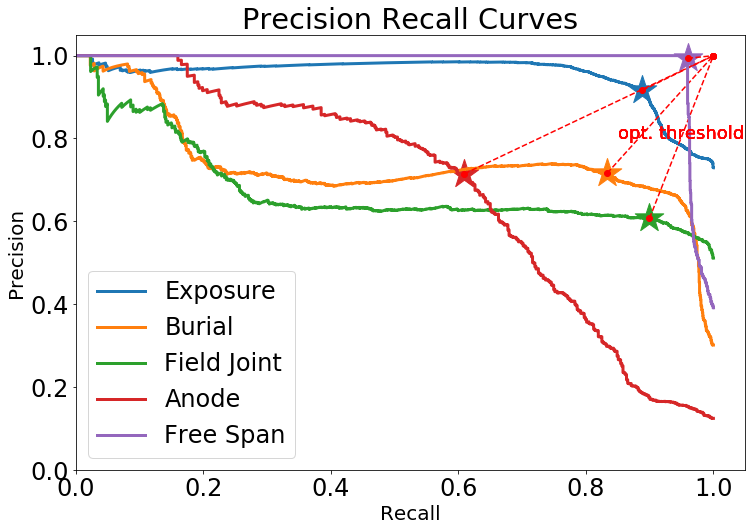

In [24]:
plot_pr_curves(0.0, y_tr, y_pr, classes, '_2d_full_size')

In [25]:
thresholds = nsea_compute_thresholds(y_tr, y_pr, classes)

In [26]:
thresholds

{'Exposure': 0.84421873,
 'Burial': 0.13289961,
 'Field Joint': 0.3128421,
 'Anode': 0.64972657,
 'Free Span': 0.020433983}

In [27]:
df_thresholds = pd.DataFrame({'Threshold': thresholds}).T
df_thresholds

,Anode,Burial,Exposure,Field Joint,Free Span
Threshold,0.649727,0.1329,0.844219,0.312842,0.020434


# Table 1

In [28]:
print(df_thresholds.to_latex(float_format=lambda x: '%.3f' % truncate_decimals(x,3)))

\begin{tabular}{lrrrrr}
\toprule
{} &  Anode &  Burial &  Exposure &  Field Joint &  Free Span \\
\midrule
Threshold &  0.649 &   0.132 &     0.844 &        0.312 &      0.020 \\
\bottomrule
\end{tabular}



## validation set

In [41]:
result_valid = new_compute_metrics(y_tr, y_pr, thresholds, classes)

/home/astamoulakatos/.conda/envs/deep/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
result_valid

,Event,Threshold,Exact Matching Score,Precision,Recall,F1-Score,tn,fp,fn,tp
0,Exposure,0.844219,0.870149,0.897475,0.913244,0.905291,1672.0,475.0,395.0,4158.0
1,Burial,0.132900,0.873881,0.803638,0.802515,0.803076,4132.0,421.0,424.0,1723.0
2,Field Joint,0.312842,0.846418,0.492228,0.853293,0.624315,4816.0,882.0,147.0,855.0
3,Anode,0.649727,0.929701,0.641208,0.573016,0.605197,5868.0,202.0,269.0,361.0
4,Free Span,0.020434,0.984925,0.953522,0.997994,0.975251,4609.0,97.0,4.0,1990.0
5,Aggregate,NaN,0.734925,0.825448,0.862463,0.834900,NaN,NaN,NaN,NaN


In [9]:
resnet.eval()
y_true = []
y_pred = []
correct = 0
with torch.no_grad():
    for X, y in valid_loader:
        X = X.to(device)
        y = Variable(y.float()).to(device) 
        #X = X.permute(0,2,1,3,4)
        y = y.squeeze(dim=1)
        y_cl = y
        y = y.float()
        output, _ = resnet(X)
        y = y.detach().cpu().numpy()
        #loss = criterion(output, y)
        preds = torch.sigmoid(output)
        predicted_cl = preds.data > 0.5
        predicted_cl = predicted_cl.to(torch.float32) 
        preds = preds.to(torch.float32) 
        preds = preds.detach().cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(y)
        correct += sum(sum(predicted_cl == y_cl)).item()
        

In [10]:
sum(sum(predicted_cl == y_cl)).item()

228

In [11]:
y_cl.shape, predicted_cl.shape

(torch.Size([50, 5]), torch.Size([50, 5]))

In [12]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

In [13]:
preds.shape

(50, 5)

In [14]:
preds = np.array(y_pred).flatten()
labels_oneh = np.array(y_true).flatten()

In [15]:
preds.shape

(32250,)

In [16]:
labels_oneh.shape

(32250,)

In [17]:
len(valid_loader.dataset)

6481

In [18]:
correct

29021

In [19]:
len(valid_loader.dataset)*5

32405

In [20]:
correct_perc = correct / (len(valid_loader.dataset)*5)
print('Accuracy of the network on the validation set images: %d %%' % (100 * correct_perc))
print(correct_perc)

Accuracy of the network on the validation set images: 89 %
0.89557167103842


In [21]:
def calc_bins(preds):
  # Assign each prediction to a bin
    num_bins = 10
    bins = np.linspace(0.1, 1, num_bins)
    binned = np.digitize(preds, bins)

  # Save the accuracy, confidence and size of each bin
    bin_accs = np.zeros(num_bins)
    bin_confs = np.zeros(num_bins)
    bin_sizes = np.zeros(num_bins)

    for bin in range(num_bins):
        bin_sizes[bin] = len(preds[binned == bin])
        if bin_sizes[bin] > 0:
            bin_accs[bin] = (labels_oneh[binned==bin]).sum() / bin_sizes[bin]
            bin_confs[bin] = (preds[binned==bin]).sum() / bin_sizes[bin]
   
    return bins, binned, bin_accs, bin_confs, bin_sizes

In [22]:
def get_metrics(preds):
    ECE = 0
    MCE = 0
    bins, _, bin_accs, bin_confs, bin_sizes = calc_bins(preds)

    for i in range(len(bins)):
        abs_conf_dif = abs(bin_accs[i] - bin_confs[i])
        ECE += (bin_sizes[i] / sum(bin_sizes)) * abs_conf_dif
        MCE = max(MCE, abs_conf_dif)

    return ECE, MCE

In [23]:
import matplotlib.patches as mpatches

def draw_reliability_graph(preds):
    ECE, MCE = get_metrics(preds)
    bins, _, bin_accs, _, _ = calc_bins(preds)

    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()

  # x/y limits
    ax.set_xlim(0, 1.05)
    ax.set_ylim(0, 1)

  # x/y labels
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')

  # Create grid
    ax.set_axisbelow(True) 
    ax.grid(color='gray', linestyle='dashed')

  # Error bars
    plt.bar(bins, bins,  width=0.1, alpha=0.3, edgecolor='black', color='r', hatch='\\')

  # Draw bars and identity line
    plt.bar(bins, bin_accs, width=0.1, alpha=1, edgecolor='black', color='b')
    plt.plot([0,1],[0,1], '--', color='gray', linewidth=2)

  # Equally spaced axes
    plt.gca().set_aspect('equal', adjustable='box')

  # ECE and MCE legend
    ECE_patch = mpatches.Patch(color='green', label='ECE = {:.2f}%'.format(ECE*100))
    MCE_patch = mpatches.Patch(color='red', label='MCE = {:.2f}%'.format(MCE*100))
    plt.legend(handles=[ECE_patch, MCE_patch])

  #plt.show()
  
    plt.savefig('calibrated_network.png', bbox_inches='tight')

#draw_reliability_graph(preds)

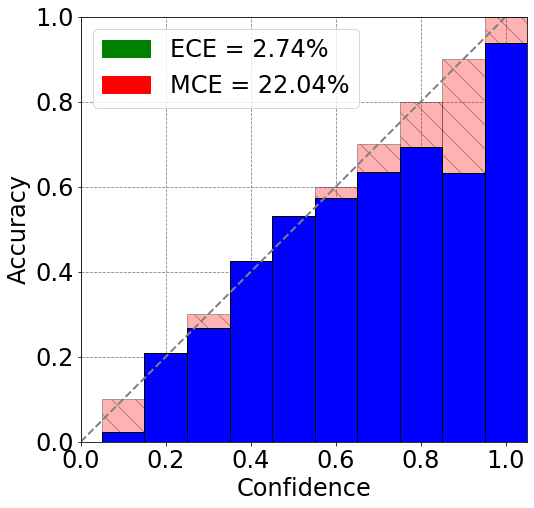

In [24]:
draw_reliability_graph(preds)

In [25]:
def T_scaling(logits, args):
    temperature = args.get('temperature', None)
    assert temperature, 'You need to provide the temperature variable in kwargs'
    temperature = temperature.unsqueeze(1).expand(logits.size(0), logits.size(1))
    return logits / temperature

In [26]:
from focal_loss_2 import *

In [27]:
temperature = nn.Parameter(torch.ones(1).cuda())
pos_wei = torch.tensor([1, 1, 1.5, 1.5, 1])
pos_wei = pos_wei.cuda()
#criterion = nn.BCEWithLogitsLoss(pos_weight = pos_wei)
criterion = FocalLoss2d(weight=pos_wei,reduction='mean',balance_param=1)
optimizer = optim.LBFGS([temperature], lr=0.001, max_iter=10000, line_search_fn='strong_wolfe')

logits_list = []
labels_list = []

In [44]:
args = {'temperature': temperature}

In [28]:
from tqdm import tqdm

In [29]:
for i, data in enumerate(tqdm(valid_loader, 0)):
    images, labels = data[0].to(device), data[1].to(device)

    resnet.eval()
    with torch.no_grad():
        out, _ = resnet(images)
        logits_list.append(out)
        labels_list.append(labels)

100%|██████████| 129/129 [01:14<00:00,  1.73it/s]


In [32]:
labels_list = torch.cat(labels_list).to(device)

In [34]:
# Create tensors
logits_list = torch.cat(logits_list).to(device)

In [35]:
logits_list

tensor([[ 3.3697, -3.1835, -0.2602, -0.5088, -4.5718],
        [ 3.9103, -3.8984, -0.7591, -0.2777, -4.8197],
        [ 4.4199, -4.0730, -0.4042, -0.8505, -3.9376],
        ...,
        [ 5.7342, -5.6636, -2.8257,  4.0261, -5.1052],
        [ 2.8688, -2.9457, -2.3747, -1.3527, -1.2590],
        [ 4.3809, -4.8363, -5.6557, -6.1716, 18.1172]], device='cuda:0')

In [36]:
logits_list.shape

torch.Size([6450, 5])

In [37]:
temps = []
losses = []

In [45]:
def _eval():
    loss = criterion(T_scaling(logits_list, args), labels_list)
    loss.backward()
    temps.append(temperature.item())
    losses.append(loss)
    return loss


In [46]:
optimizer.step(_eval)

tensor(0.0133, device='cuda:0', grad_fn=<MulBackward0>)

Final T_scaling factor: 1.25


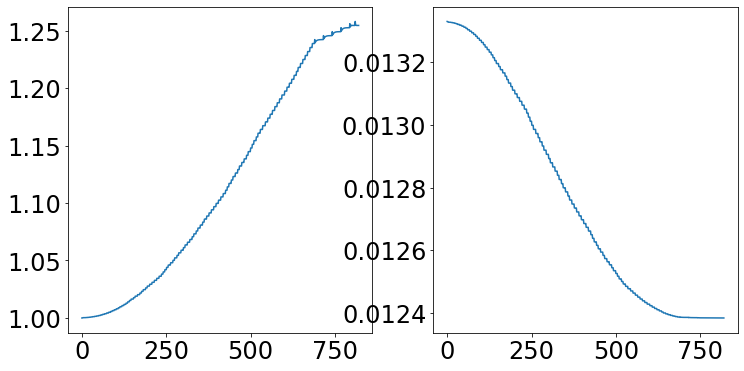

In [47]:
print('Final T_scaling factor: {:.2f}'.format(temperature.item()))

plt.subplot(121)
plt.plot(list(range(len(temps))), temps)

plt.subplot(122)
plt.plot(list(range(len(losses))), losses)
plt.show()


In [73]:
def test(loader, calibration_method=None, **kwargs):
    resnet.eval()
    y_true = []
    y_pred = []
    correct = 0
    y_predss = []
    y_truess = []
    with torch.no_grad():
        for X, y in loader:
            X = X.to(device)
            y = Variable(y.float()).to(device) 
            #X = X.permute(0,2,1,3,4)
            y = y.squeeze(dim=1)
            y_cl = y
            y = y.float()
            output, _ = resnet(X)
            y = y.detach().cpu().numpy()
            #loss = criterion(output, y)
            if calibration_method:
                output = calibration_method(output, kwargs)
                
            preds = torch.sigmoid(output)
            predicted_cl = preds.data > 0.5
            predicted_cl = predicted_cl.to(torch.float32) 
            preds = preds.to(torch.float32) 
            preds = preds.detach().cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(y)
            correct += sum(sum(predicted_cl == y_cl)).item()
            y_predss.append(preds)
            y_truess.append(y)
            
    preds = np.array(y_pred).flatten()
    labels_oneh = np.array(y_true).flatten()
            
    correct_perc = correct / (len(valid_loader.dataset)*5)
    print('Accuracy of the network on the validation set images: %d %%' % (100 * correct_perc))
    print(correct_perc)
    return preds, labels_oneh, y_predss, y_truess

In [57]:
preds_calibrated, _, y_pred, y_true = test(T_scaling, temperature=temperature)

Accuracy of the network on the validation set images: 89 %
0.8957876870853263


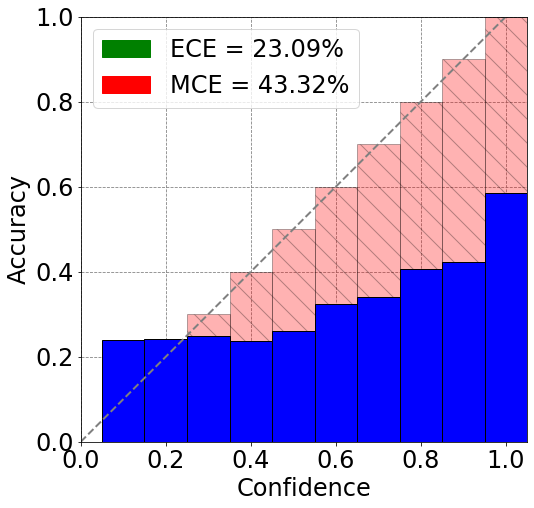

In [58]:
draw_reliability_graph(preds_calibrated)

In [59]:
len(preds_calibrated)

32250

In [60]:
from helpers_thresholds import *

In [61]:
y_tr = np.vstack([t.__array__() for tensor in y_true for t in tensor])

In [62]:
y_pr = np.vstack([t.__array__() for tensor in y_pred for t in tensor])

In [63]:
classes = ['Exposure', 'Burial', 'Field Joint', 'Anode', 'Free Span']

0.8847144697294976 0.9237839049540462 0.9038271740322403
Optimal  Exposure  Threshold =  0.6724582

0.9157366071428571 0.6929898648648649 0.7889423076923077
Optimal  Burial  Threshold =  0.20361295

0.9373246024321796 0.6212027278363298 0.7472035794183445
Optimal  Field Joint  Threshold =  0.19795817

0.5992647058823529 0.6777546777546778 0.6360975609756098
Optimal  Anode  Threshold =  0.39408758

0.9936218678815489 0.9977127172918573 0.9956630906185802
Optimal  Free Span  Threshold =  0.41734385



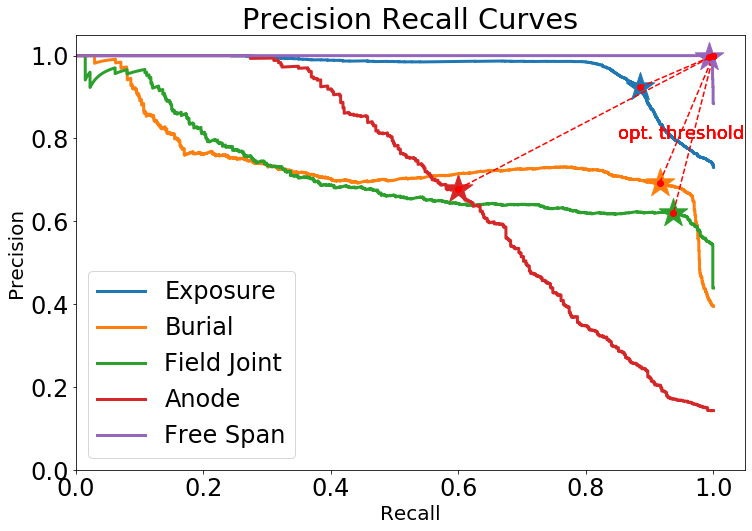

In [64]:
plot_pr_curves(0.0, y_tr, y_pr, classes, '_2d_full_size')

In [65]:
thresholds = nsea_compute_thresholds(y_tr, y_pr, classes)

In [66]:
thresholds

{'Exposure': 0.6724582,
 'Burial': 0.20361295,
 'Field Joint': 0.19795817,
 'Anode': 0.39408758,
 'Free Span': 0.41734385}

In [67]:
df_thresholds = pd.DataFrame({'Threshold': thresholds}).T
df_thresholds

,Anode,Burial,Exposure,Field Joint,Free Span
Threshold,0.394088,0.203613,0.672458,0.197958,0.417344


# Table 1

In [68]:
print(df_thresholds.to_latex(float_format=lambda x: '%.3f' % truncate_decimals(x,3)))

\begin{tabular}{lrrrrr}
\toprule
{} &  Anode &  Burial &  Exposure &  Field Joint &  Free Span \\
\midrule
Threshold &  0.394 &   0.203 &     0.672 &        0.197 &      0.417 \\
\bottomrule
\end{tabular}



## validation set

In [69]:
result_valid = new_compute_metrics(y_tr, y_pr, thresholds, classes)

In [70]:
result_valid

,Event,Threshold,Exact Matching Score,Precision,Recall,F1-Score,tn,fp,fn,tp
0,Exposure,0.672458,0.864031,0.923784,0.884714,0.903827,1452.0,340.0,537.0,4121.0
1,Burial,0.203613,0.863876,0.692990,0.915737,0.788942,3931.0,727.0,151.0,1641.0
2,Field Joint,0.197958,0.894884,0.621203,0.937325,0.747204,4770.0,611.0,67.0,1002.0
3,Anode,0.394088,0.942171,0.677755,0.599265,0.636098,5751.0,155.0,218.0,326.0
4,Free Span,0.417344,0.997054,0.997713,0.993622,0.995663,4250.0,5.0,14.0,2181.0
5,Aggregate,NaN,0.729767,0.822894,0.877132,0.840171,NaN,NaN,NaN,NaN


In [74]:
preds_calibrated, _, y_pred, y_true = test(test_loader, T_scaling, temperature=temperature)

Accuracy of the network on the validation set images: 94 %
0.9419842616880111


In [81]:
draw_reliability_graph(preds_calibrated)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 32250 but corresponding boolean dimension is 33500

In [75]:
y_tr = np.vstack([t.__array__() for tensor in y_true for t in tensor])

In [76]:
y_pr = np.vstack([t.__array__() for tensor in y_pred for t in tensor])

In [77]:
result_test = new_compute_metrics(y_tr, y_pr, thresholds, classes)

In [78]:
result_test

,Event,Threshold,Exact Matching Score,Precision,Recall,F1-Score,tn,fp,fn,tp
0,Exposure,0.672458,0.873582,0.898516,0.917655,0.907985,1674.0,472.0,375.0,4179.0
1,Burial,0.203613,0.860000,0.760345,0.821994,0.789969,3998.0,556.0,382.0,1764.0
2,Field Joint,0.197958,0.844478,0.489090,0.918082,0.638194,4739.0,960.0,82.0,919.0
3,Anode,0.394088,0.935672,0.688091,0.577778,0.628128,5905.0,165.0,266.0,364.0
4,Free Span,0.417344,0.995821,0.986145,1.000000,0.993024,4679.0,28.0,0.0,1993.0
5,Aggregate,NaN,0.735522,0.818930,0.874627,0.837040,NaN,NaN,NaN,NaN


In [79]:
print(result_test.to_latex(float_format=lambda x: '%.3f' % truncate_decimals(x,3)))

\begin{tabular}{llrrrrrrrrr}
\toprule
{} &        Event &  Threshold &  Exact Matching Score &  Precision &  Recall &  F1-Score &       tn &      fp &      fn &       tp \\
\midrule
0 &     Exposure &      0.672 &                 0.873 &      0.898 &   0.917 &     0.907 & 1674.000 & 472.000 & 375.000 & 4179.000 \\
1 &       Burial &      0.203 &                 0.860 &      0.760 &   0.821 &     0.789 & 3998.000 & 556.000 & 382.000 & 1764.000 \\
2 &  Field Joint &      0.197 &                 0.844 &      0.489 &   0.918 &     0.638 & 4739.000 & 960.000 &  82.000 &  919.000 \\
3 &        Anode &      0.394 &                 0.935 &      0.688 &   0.577 &     0.628 & 5905.000 & 165.000 & 266.000 &  364.000 \\
4 &    Free Span &      0.417 &                 0.995 &      0.986 &   1.000 &     0.993 & 4679.000 &  28.000 &   0.000 & 1993.000 \\
5 &    Aggregate &        nan &                 0.735 &      0.818 &   0.874 &     0.837 &      nan &     nan &     nan &      nan \\
\bottomrule
\e

In [80]:
precision, recall, f1, _ = precision_recall_fscore_support(y_tr, y_pr)

In [ ]:
fop_uncalibrated, mpv_uncalibrated = calibration_curve(testy, yhat_uncalibrated, n_bins=10, normalize=True)